In [1]:

import numpy as np 
import pandas as pd 
import os
import cv2

## Labels

In [2]:
labels = os.listdir(r"archive/train")

In [3]:
labels

['Closed', 'no_yawn', 'Open', 'yawn']

## Visualize A random image

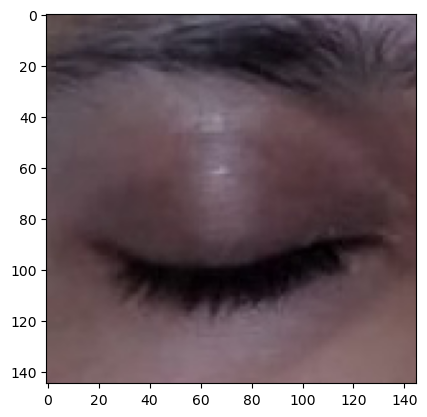

In [4]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(r"archive/train/Closed/_0.jpg"))

## Image array

In [5]:
a = plt.imread(r"archive/train/yawn/10.jpg")

## Image shape

In [6]:
a.shape

(480, 640, 3)

## Visualize yawn image(Background is unnecessary. We need only face image array) 


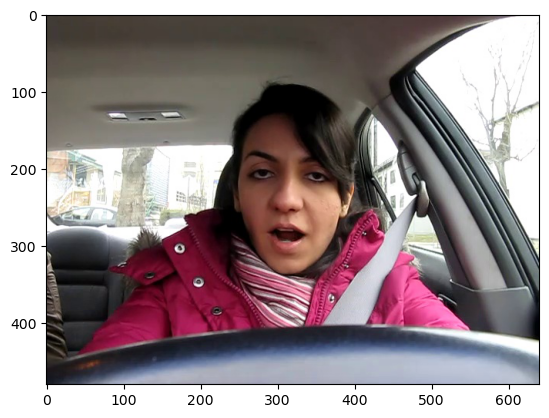

In [7]:
plt.imshow(plt.imread(r"archive/train/yawn/10.jpg"))

## Take only face(For yawn and not_yawn)

In [8]:
def face_for_yawn(direc=r"archive/train", face_cas_path=r"haarcascade_frontalface_default.xml"):#archive(1)\haarcascade_frontalface_default.xml
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


## For Closed and Open eye

In [9]:
def get_data(dir_path=r"archive/train", face_cas=r"haarcascade_frontalface_default.xml", eye_cas=r"haarcascade.xml"):#archive(1)\haarcascade_frontalface_default.xml", eye_cas=r"archive(1)\haarcascade.xml
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [10]:
data_train = get_data()

2
3


## Extend data and Convert array

In [11]:
def append_data():
    #total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    #print(yaw_no)
    return (yaw_no)#np.array


## New variable to store

In [12]:
new_data = append_data()

0
1
2
3


# Separate label and features

In [13]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

## Reshape the Array

In [14]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

## LabelBinarizer

In [15]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

## Label array

In [16]:
y = np.array(y)

## Train Test split

In [17]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

## Length of X_test

In [18]:
len(X_test)

578

## Import some dependencies

In [25]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

## Data Augmentation

In [26]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)


#train_generator = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_generator = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [27]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145,145,3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [28]:
history = model.fit(train_generator, epochs=5, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/5
43/43 [==============================] - 144s 3s/step - loss: 1.0443 - accuracy: 0.5212 - val_loss: 0.5128 - val_accuracy: 0.8097
Epoch 2/5
43/43 [==============================] - 122s 3s/step - loss: 0.5666 - accuracy: 0.7788 - val_loss: 0.4762 - val_accuracy: 0.7837
Epoch 3/5
43/43 [==============================] - 115s 3s/step - loss: 0.4075 - accuracy: 0.8352 - val_loss: 0.3708 - val_accuracy: 0.8391
Epoch 4/5
43/43 [==============================] - 110s 3s/step - loss: 0.3436 - accuracy: 0.8493 - val_loss: 0.3053 - val_accuracy: 0.8858
Epoch 5/5
43/43 [==============================] - 112s 3s/step - loss: 0.2916 - accuracy: 0.8849 - val_loss: 0.2702 - val_accuracy: 0.8962


## History

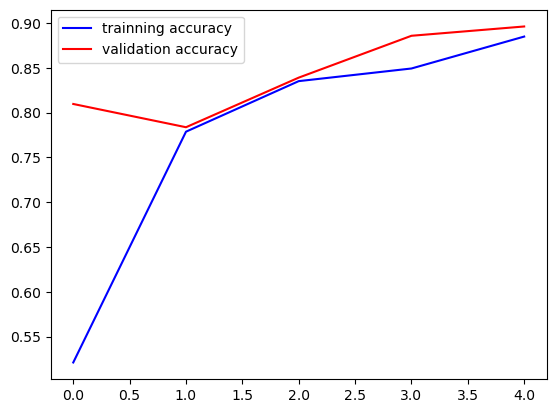

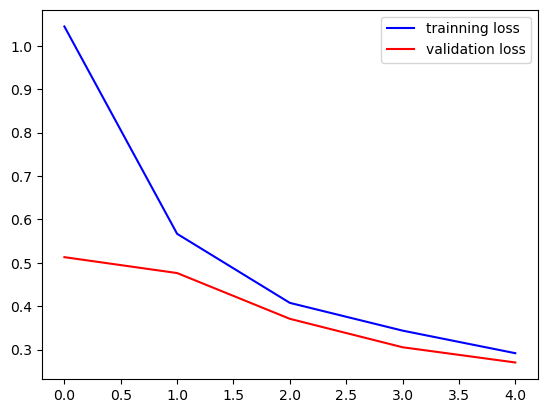

In [29]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

## Save Model

In [30]:
model.save("drowiness_new7.h5")

In [31]:
model.save("drowiness_new7.model")

INFO:tensorflow:Assets written to: drowiness_new7.model\assets


INFO:tensorflow:Assets written to: drowiness_new7.model\assets


# Prediction

In [32]:
prediction = (model.predict(X) > 0.5).astype("int32")

61/61 [==============================] - 39s 583ms/step


In [33]:
prediction

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

# classification report

In [34]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [35]:
#from sklearn.metrics import classification_report
#print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

# predicting function

In [36]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas=r"haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("drowiness_new7.h5")#E:\drowsy eye\driver_drowsiness_system_CNN-main\drowiness_new7.h5

# Prediction 
## 0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [37]:
# prepare("../input/drowsiness-dataset/train/no_yawn/1068.jpg")
prediction = model.predict([prepare(r"archive/train/no_yawn/1067.jpg")])
np.argmax(prediction)

1/1 [==============================] - 3s 3s/step


1

In [38]:
prediction = model.predict([prepare(r"archive/train/Closed/_101.jpg")])
np.argmax(prediction)

1/1 [==============================] - 3s 3s/step


3

In [39]:
prediction = model.predict([prepare(r"archive/train/Closed/_104.jpg")])
np.argmax(prediction)

1/1 [==============================] - 1s 683ms/step


2

In [40]:
prediction = model.predict([prepare(r"archive/train/yawn/12.jpg")])
np.argmax(prediction)


1/1 [==============================] - 1s 763ms/step


3

In [42]:
import cv2
import numpy as np

from keras.models import load_model
#from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array
from playsound import playsound
from threading import Thread


def start_alarm(sound):#sound
    """Play the alarm sound"""
    playsound(sound)


classes = ['Closed', 'Open']
face_cascade = cv2.CascadeClassifier(r"E:\projects\driver_drowsiness_system_CNN-main\haarcascade_frontalface_default.xml")
left_eye_cascade = cv2.CascadeClassifier(r"E:\projects\driver_drowsiness_system_CNN-main\haarcascade_lefteye_2splits.xml")
right_eye_cascade = cv2.CascadeClassifier(r"E:\projects\driver_drowsiness_system_CNN-main\haarcascade_righteye_2splits.xml")
cap = cv2.VideoCapture(0)
model = load_model(r"E:\projects\driver_drowsiness_system_CNN-main\drowiness_new7.h5")
count = 0
alarm_on = False
alarm_sound = "E:\projects\driver_drowsiness_system_CNN-main\malarm.wav"
status1 = ''
status2 = ''

while True:
    _, frame = cap.read()
    height = frame.shape[0]
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 1)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        left_eye = left_eye_cascade.detectMultiScale(roi_gray)
        right_eye = right_eye_cascade.detectMultiScale(roi_gray)
        for (x1, y1, w1, h1) in left_eye:
            cv2.rectangle(roi_color, (x1, y1), (x1 + w1, y1 + h1), (0, 255, 0), 1)
            eye1 = roi_color[y1:y1+h1, x1:x1+w1]
            eye1 = cv2.resize(eye1, (145, 145))
            eye1 = eye1.astype('float') / 255.0
            eye1 = img_to_array(eye1)
            eye1 = np.expand_dims(eye1, axis=0)
            pred1 = model.predict(eye1)
            status1=np.argmax(pred1)
            #print(status1)
            #status1 = classes[pred1.argmax(axis=-1)[0]]
            break

        for (x2, y2, w2, h2) in right_eye:
            cv2.rectangle(roi_color, (x2, y2), (x2 + w2, y2 + h2), (0, 255, 0), 1)
            eye2 = roi_color[y2:y2 + h2, x2:x2 + w2]
            eye2 = cv2.resize(eye2, (145, 145))
            eye2 = eye2.astype('float') / 255.0
            eye2 = img_to_array(eye2)
            eye2 = np.expand_dims(eye2, axis=0)
            pred2 = model.predict(eye2)
            status2=np.argmax(pred2)
            #print(status2)
            #status2 = classes[pred2.argmax(axis=-1)[0]]
            break

        # If the eyes are closed, start counting
        if status1 == 2 and status2 == 2:
        #if pred1 == 2 and pred2 == 2:
            count += 1
            cv2.putText(frame, "Eyes Closed, Frame count: " + str(count), (10, 30), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 1)
            # if eyes are closed for 10 consecutive frames, start the alarm
            
            if count >= 10:
                cv2.putText(frame, "Drowsiness Alert!!!", (100, height-20), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2)
                if not alarm_on:
                    alarm_on = True
                    # play the alarm sound in a new thread
                    t = Thread(target=start_alarm, args=(alarm_sound,))
                    t.daemon = True
                    t.start()

        else:
            cv2.putText(frame, "Eyes Open", (10, 30), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 1)
            count = 0
            alarm_on = False

    cv2.imshow("Drowsiness Detector", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

AttributeError: 'NoneType' object has no attribute 'shape'